In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import string
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import random
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
intents = json.loads(open('dialogbot.json').read())

In [3]:
intents

{'intents': [{'tag': 'mendeklarasikan_variabel',
   'patterns': ['cara mendeklarasikan variabel di php?', 'variabel php'],
   'responses': ['Di php, variabel dapat dideklarasikan dengan $nama_variabel. Contoh: $nama = "John";'],
   'context_set': ''},
  {'tag': 'crud',
   'patterns': ['buatkan PHP crud dong', 'script PHP crud', 'crud PHP'],
   'responses': ['Tentu akan kubuatkan, buat dahulu file config.php: <?php\n/**\n * using mysqli_connect for database connection\n */\n\n$databaseHost = \'localhost\';\n$databaseName = \'crud_db\';\n$databaseUsername = \'root\';\n$databasePassword = \'\';\n\n$mysqli = mysqli_connect($databaseHost, $databaseUsername, $databasePassword, $databaseName);\n\n?> Lalu buat file index.php, masukan kode : <?php\n// Create database connection using config file\ninclude_once("config.php");\n\n// Fetch all users data from database\n$result = mysqli_query($mysqli, "SELECT * FROM users ORDER BY id DESC");\n?>\n\n<html>\n<head>\n    <title>Homepage</title>\n</head

In [4]:

inputs = []
tags = []
responses = {}
classes = []
documents = []
ignore_words = ['?', '!', '.', ',', '<','>', '-', ':', ';']
words = []

for intent in intents['intents']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])
        for pattern in intent['patterns']:
            w = nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w, intent['tag']))

            if intent['tag'] not in classes:
                classes.append(intent['tag'])

df = pd.DataFrame({"patterns": inputs, "tag": tags})

In [5]:
data = pd.DataFrame({"inputs":inputs,
                    "tags":tags})

In [6]:
data

,inputs,tags
0,cara mendeklarasikan variabel di php?,mendeklarasikan_variabel
1,variabel php,mendeklarasikan_variabel
2,buatkan PHP crud dong,crud
3,script PHP crud,crud
4,crud PHP,crud
...,...,...
99,Terima Kasih,berakhir
100,thanks bro,berakhir
101,makasih bot,berakhir
102,good bye,berakhir


In [7]:
data["inputs"] = data["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data["inputs"] = data["inputs"].apply(lambda wrd: ''.join(wrd))

In [8]:
data

,inputs,tags
0,cara mendeklarasikan variabel di php,mendeklarasikan_variabel
1,variabel php,mendeklarasikan_variabel
2,buatkan php crud dong,crud
3,script php crud,crud
4,crud php,crud
...,...,...
99,terima kasih,berakhir
100,thanks bro,berakhir
101,makasih bot,berakhir
102,good bye,berakhir


In [9]:


lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lematized words", words)

130 unique lematized words ["'", "'hello", '(', ')', 'ada', 'adalah', 'afternoon', 'antara', 'apa', 'apakah', 'arti', 'bagaimana', 'bagikan', 'beda', 'bedanya', 'benar', 'berikan', 'bicara', 'bot', 'bro', 'buatkan', 'butuh', 'bye', 'cara', 'contoh', 'crud', 'dalam', 'dan', 'dari', 'data', 'database', 'datatabel', 'datatable', 'datatables', 'datatble', 'delete', 'dengan', 'di', 'diphp', 'dong', 'edit', 'entri', 'form', 'fungsi', 'gambar', 'get', 'gimana', 'good', 'hai', 'halaman', 'hallo', 'hello', 'hi', 'html', 'htmll', 'hy', 'ingin', 'ini', 'itu', 'kabarmu', 'kamu', 'kasih', 'kawan', 'kbarmu', 'ke', 'kesalahan', 'kode', 'komentar', 'kondisi', 'link', 'makasih', 'malam', 'malem', 'mau', 'membuat', 'menambahkan', 'menampilkan', 'mendeklarasikan', 'menggunakan', 'menghapus', 'menulis', 'menyisipkan', 'method', 'morning', 'mu', 'nama', 'nanya', 'night', 'nya', 'pada', 'pagi', 'panggil', 'pengertian', 'penggunaan', 'penulisan', 'perbedaan', 'periksa', 'perlu', 'php', 'post', 'print', 'puny

In [10]:
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data["inputs"])
train = tokenizer.texts_to_sequences(data["inputs"])

In [11]:
train

[[3, 62, 40, 20, 2],
 [40, 2],
 [4, 2, 24, 41],
 [5, 2, 24],
 [24, 2],
 [7, 63, 64, 65, 25, 26, 27],
 [66, 67, 27, 26, 25, 7],
 [25, 26, 27, 68],
 [8, 3, 9, 28],
 [4, 28],
 [28, 42, 1],
 [8, 3, 43, 29, 20, 1],
 [4, 29, 1],
 [30, 29, 69],
 [7, 31, 1],
 [7, 44, 1],
 [1, 45],
 [1, 46],
 [7, 31, 2],
 [2, 45],
 [7, 44, 2, 31],
 [70, 2],
 [46, 2],
 [4, 5, 2, 21],
 [71, 12, 13, 2],
 [10, 72, 3, 73, 5, 2],
 [47, 3, 32, 2, 11, 9, 48, 74],
 [75, 76, 77, 78, 79, 13, 80, 81, 33],
 [82, 83, 30, 34, 33],
 [10, 84, 30, 34, 33],
 [10, 17, 12, 35, 1, 11, 9, 49],
 [8, 3, 32, 50, 1],
 [49, 1],
 [85],
 [86],
 [7, 87, 51, 6, 88, 52, 1, 6, 11, 32, 50],
 [6, 53, 35, 2, 11, 9, 22],
 [8, 3, 9, 22, 2, 21],
 [5, 22],
 [10, 17, 12, 89, 22, 20, 2],
 [4, 5, 2, 36],
 [5, 36],
 [36, 90],
 [4, 5, 2, 11, 54, 91],
 [10, 17, 12, 13, 37, 2],
 [37],
 [8, 3, 9, 92, 37, 42, 2],
 [6, 51, 35, 11, 54, 93, 94, 95],
 [4, 5, 1, 21],
 [5, 1],
 [1, 21],
 [4, 13, 1, 15, 14],
 [6, 96, 97, 3, 98, 14, 20, 1],
 [13, 1, 14],
 [4, 14],
 [4

In [12]:
x_train = pad_sequences(train)

In [13]:
x_train

array([[  0,   0,   0, ...,  40,  20,   2],
       [  0,   0,   0, ...,   0,  40,   2],
       [  0,   0,   0, ...,   2,  24,  41],
       ...,
       [  0,   0,   0, ...,   0, 123,  16],
       [  0,   0,   0, ...,   0,  60, 124],
       [  0,   0,   0, ..., 125, 126,  41]])

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(data["tags"])
y_train

array([ 8,  8,  3,  3,  3,  6,  6,  6, 23, 23, 23,  7,  7,  7, 10, 10, 10,
       10, 11, 11, 11, 11, 11,  5,  5,  5,  5,  4,  4,  4, 18, 18, 18, 18,
       18, 18, 21, 21, 21, 21, 20, 20, 20, 19, 19, 19, 19, 19,  2,  2,  2,
       22, 22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24,  9,  9,  9,  9,  9,
        9,  9,  9, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 14, 14, 14, 14,
       12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,  0,  0,  0,
        0,  1])

In [15]:
input_shape = x_train.shape[1]
print(input_shape)

11


In [16]:
unique_words = len(tokenizer.word_index)
output_length = le.classes_.shape[0]
print("unique words: ", unique_words)
print("output length: ", output_length)

unique words:  126
output length:  25


In [17]:
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

25 classes ['berakhir', 'bertanya', 'contoh_html', 'crud', 'error', 'example_php', 'get_dan_post', 'komentar', 'mendeklarasikan_variabel', 'menyapa', 'pengertian_html', 'pengertian_php', 'pertanyaan_kabar', 'pertanyaan_nama', 'sapaan_malam', 'sapaan_pagi', 'sapaan_siang', 'sapaan_sore', 'script_datatable', 'script_delete', 'script_edit', 'script_form', 'script_gambar', 'script_link', 'script_tabel']


In [18]:
vocalbulary = len(tokenizer.word_index)
print("number of unique words : ", vocalbulary)

output_length = le.classes_.shape[0]
print("output lenghth", output_length)

number of unique words :  126
output lenghth 25


In [19]:
from nltk.util import flatten
from tensorflow.keras.layers import Input, Embedding, LSTM, Flatten, Dense
from tensorflow.keras.models import Model
# Assuming you have defined input_range and output_length elsewhere in your code

i = Input(shape=(input_shape,))
x = Embedding(vocalbulary + 1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)
# Kompilasi model

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [20]:
trains = model.fit(x_train, y_train, epochs=800, validation_data=(x_train, y_train))

Epoch 1/800


4/4 [==============================] - 3s 205ms/step - loss: 3.2173 - accuracy: 0.0481 - val_loss: 3.2134 - val_accuracy: 0.0577
Epoch 2/800
4/4 [==============================] - 0s 22ms/step - loss: 3.2126 - accuracy: 0.0673 - val_loss: 3.2095 - val_accuracy: 0.0769
Epoch 3/800
4/4 [==============================] - 0s 20ms/step - loss: 3.2086 - accuracy: 0.0865 - val_loss: 3.2055 - val_accuracy: 0.0769
Epoch 4/800
4/4 [==============================] - 0s 21ms/step - loss: 3.2043 - accuracy: 0.0769 - val_loss: 3.2012 - val_accuracy: 0.0865
Epoch 5/800
4/4 [==============================] - 0s 23ms/step - loss: 3.1998 - accuracy: 0.0865 - val_loss: 3.1963 - val_accuracy: 0.0865
Epoch 6/800
4/4 [==============================] - 0s 21ms/step - loss: 3.1953 - accuracy: 0.0865 - val_loss: 3.1908 - val_accuracy: 0.0865
Epoch 7/800
4/4 [==============================] - 0s 20ms/step - loss: 3.1892 - accuracy: 0.0865 - val_loss: 3.1853 - val_accuracy: 0.0865
Epoch 8/800
4/4 [

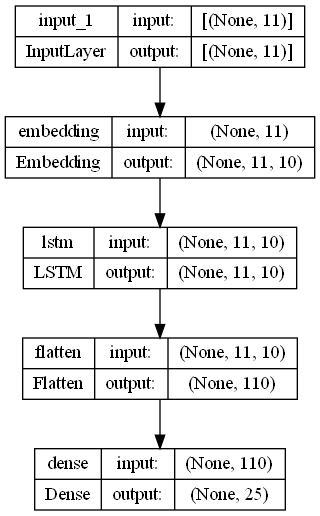

In [21]:
from keras.utils import plot_model
plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

Text(0.5, 1.0, 'loss')

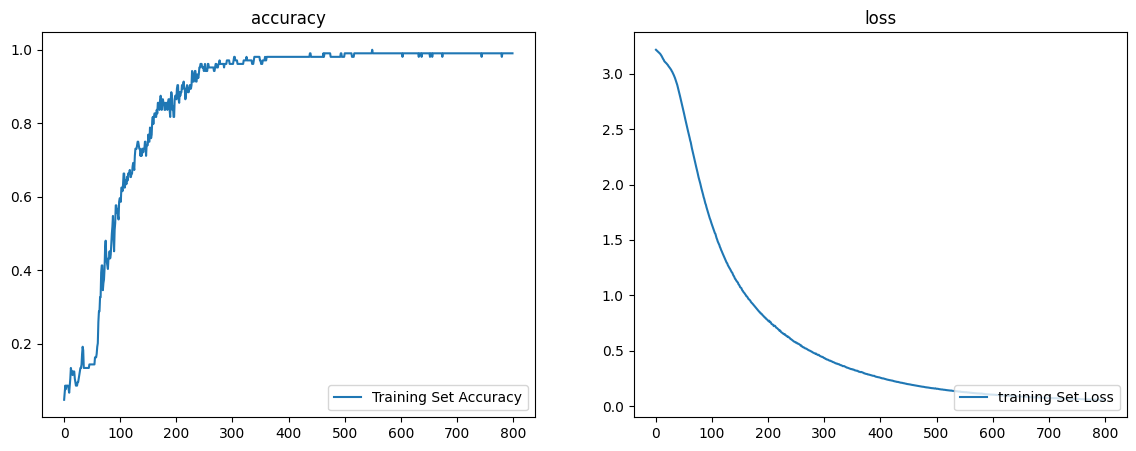

In [22]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(trains.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(trains.history['loss'],label='training Set Loss')
plt.legend(loc='lower right')
plt.title('loss')

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(x_train).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(y_train, Y_preds)))
print("\nClassification Report : ")
print(classification_report(y_train, Y_preds, target_names=classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_train, Y_preds))

4/4 [==============================] - 0s 3ms/step
Test Accuracy : 0.9903846153846154

Classification Report : 
                          precision    recall  f1-score   support

                berakhir       1.00      1.00      1.00         4
                bertanya       1.00      1.00      1.00         1
             contoh_html       1.00      1.00      1.00         3
                    crud       1.00      1.00      1.00         3
                   error       1.00      1.00      1.00         3
             example_php       1.00      1.00      1.00         4
            get_dan_post       1.00      1.00      1.00         3
                komentar       1.00      1.00      1.00         3
mendeklarasikan_variabel       1.00      1.00      1.00         2
                 menyapa       1.00      1.00      1.00         8
         pengertian_html       1.00      1.00      1.00         4
          pengertian_php       1.00      1.00      1.00         5
        pertanyaan_kabar     

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(x_train).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(y_train, Y_preds)))
print("\nClassification Report : ")
print(classification_report(y_train, Y_preds, target_names=classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_train, Y_preds))

4/4 [==============================] - 0s 4ms/step
Test Accuracy : 0.9903846153846154

Classification Report : 
                          precision    recall  f1-score   support

                berakhir       1.00      1.00      1.00         4
                bertanya       1.00      1.00      1.00         1
             contoh_html       1.00      1.00      1.00         3
                    crud       1.00      1.00      1.00         3
                   error       1.00      1.00      1.00         3
             example_php       1.00      1.00      1.00         4
            get_dan_post       1.00      1.00      1.00         3
                komentar       1.00      1.00      1.00         3
mendeklarasikan_variabel       1.00      1.00      1.00         2
                 menyapa       1.00      1.00      1.00         8
         pengertian_html       1.00      1.00      1.00         4
          pengertian_php       1.00      1.00      1.00         5
        pertanyaan_kabar     

In [25]:
from sklearn.metrics import precision_score, recall_score


def score_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted,average= 'macro')
    recall = recall_score(y_test, y_predicted,average='macro')
    print("accuracy = %0.3f, precision = %0.3f, recall = %0.3f" % (accuracy, precision, recall))
score_metrics(y_train, Y_preds)

accuracy = 0.990, precision = 0.990, recall = 0.987


In [26]:
import seaborn as sns
classes = ['variabel', 'crud', 'get_dan_post', 'link_php', 'komentar',
       'pengertian_html', 'pengertian_php', 'php', 'error',
       'datatable_html', 'form_php', 'edit_php', 'delete_php', 'html',
       'gambar_html', 'tabel_html', 'menyapa', 'sapaan_pagi',
       'sapaan_siang', 'sapaan_sore', 'sapaan_malam', 'sapaan_umum',
       'pertanyaan_kabar', 'pertanyaan_nama', 'berakhir', 'bertanya']
def plot_confusion_matrix(y_test, y_predicted, title='Confusion Matrix'):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

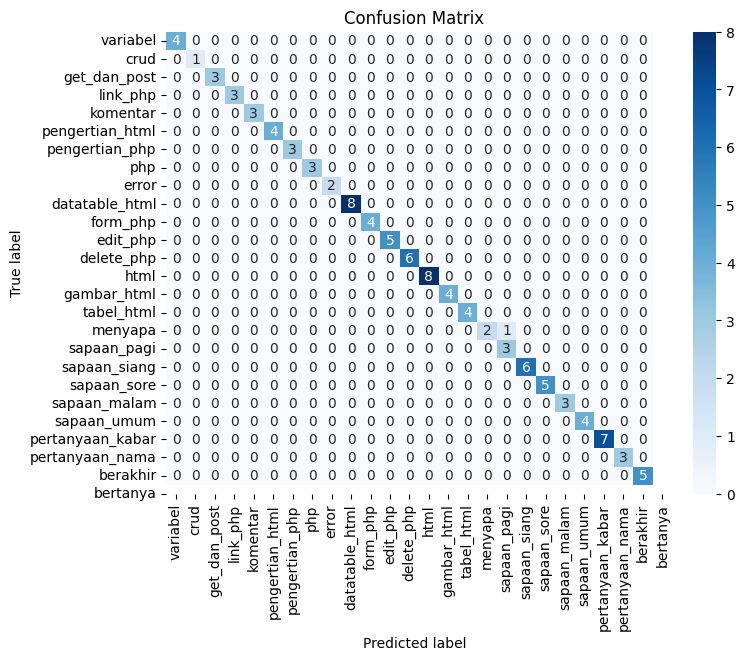

In [27]:
plot_confusion_matrix(y_train, Y_preds)

In [28]:

model.save('Models.h5')

c:\Users\ACER\miniconda3\envs\ModelLSTM\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
while True:
    textList = []
    user_input = input("Kamu: ")
    prediction_input = []

    for letter in user_input:
        if letter not in string.punctuation:
            prediction_input.append(letter.lower())

    prediction_input = ''.join(prediction_input)
    textList.append(prediction_input)
    
    prediction_input = tokenizer.texts_to_sequences(textList)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input], input_shape)
    
    output = model.predict(prediction_input)
    output = output.argmax()
    
    response_tag = le.inverse_transform([output])[0]
    print("BOT: ", random.choice(responses[response_tag]))
    if response_tag == 'goodbye':
        break

1/1 [==============================] - 0s 270ms/step
BOT:  hi!
1/1 [==============================] - 0s 48ms/step
BOT:  Selamat pagi! Ada yang perlu Anda tanyakan?
1/1 [==============================] - 0s 45ms/step
BOT:  php adalah bahasa pemrograman skrip sisi server yang digunakan untuk pengembangan web.
1/1 [==============================] - 0s 41ms/step
BOT:  HTML (Hypertext Markup Language) adalah bahasa markah standar untuk membuat dan merancang halaman web.
1/1 [==============================] - 0s 49ms/step
BOT:  Sama-sama! Jika Anda memiliki pertanyaan lebih lanjut atau ada hal lain yang bisa saya bantu
1/1 [==============================] - 0s 45ms/step
BOT:  Selamat siang! Bagaimana saya bisa membantu Anda hari ini?
1/1 [==============================] - 0s 40ms/step
BOT:  Maaf, tetapi saya tidak memiliki kemampuan untuk mengetahui atau menyimpan informasi pribadi tentang pengguna. Saya dirancang untuk menghormati privasi dan tidak dapat menyimpan informasi pribadi
1/1 [==

KeyboardInterrupt: Interrupted by user

In [27]:
model.save('ChatLSTM.h5')

c:\Users\ACER\miniconda3\envs\ModelLSTM\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('ChatV.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmprqh6qle7\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmprqh6qle7\assets


17432